In [24]:
#Importing Libraries
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D,Dropout,Dense
from tensorflow.keras import layers, optimizers, callbacks  
from sklearn.utils.class_weight import compute_class_weight  
from tensorflow.keras.applications import EfficientNetV2B2 
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import gradio as gr
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [2]:
#Extracting Data
zip_path = "archive.zip"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

data_path = "TrashType_Image_Dataset"
print("✅ Dataset extracted.")

✅ Dataset extracted.



Showing samples for class: cardboard


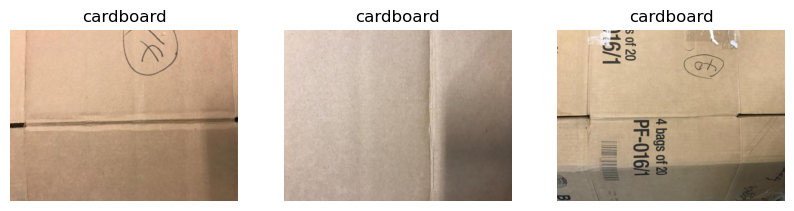


Showing samples for class: glass


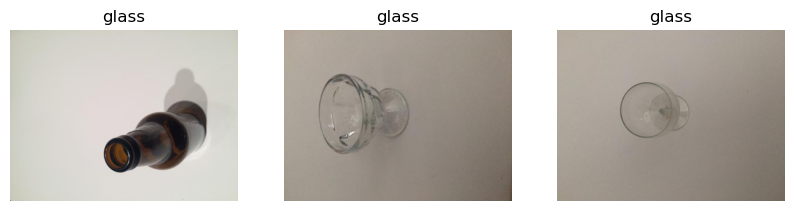


Showing samples for class: metal


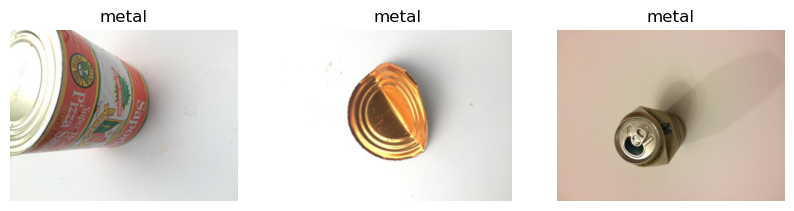


Showing samples for class: paper


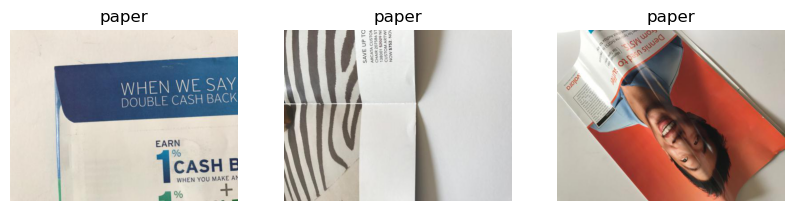


Showing samples for class: plastic


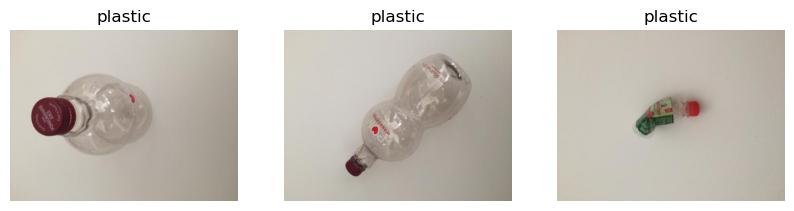


Showing samples for class: trash


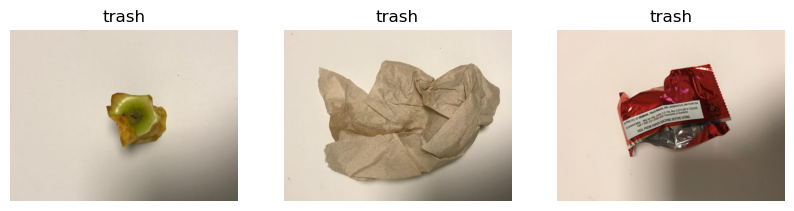

In [3]:
#View Samples
classes = os.listdir(data_path)

for class_name in classes:
    class_folder = os.path.join(data_path, class_name)
    image_files = os.listdir(class_folder)[:3]

    print(f"\nShowing samples for class: {class_name}")
    plt.figure(figsize=(10, 3))

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(class_folder, img_name)
        img = plt.imread(img_path)

        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

    plt.show()

In [4]:
#Preprocessing and datasplit
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(260, 260),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=(260, 260),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


{'cardboard': 403, 'glass': 501, 'metal': 410, 'paper': 594, 'plastic': 482, 'trash': 137}


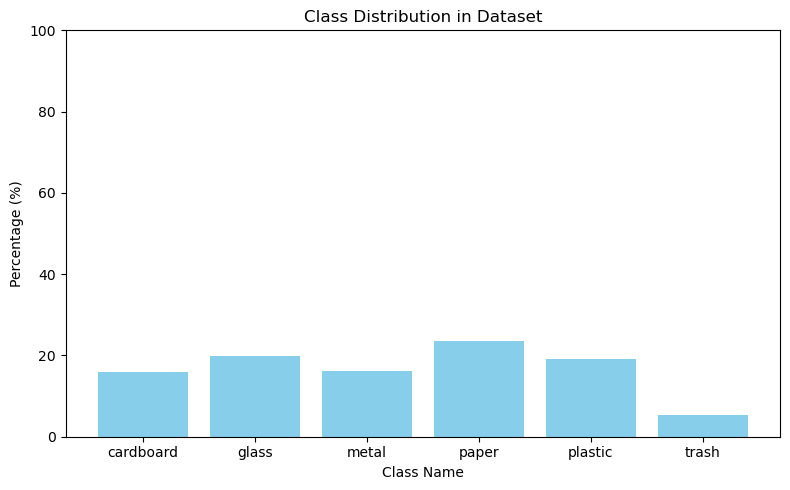

Class image counts: {'cardboard': 15.95, 'glass': 19.83, 'metal': 16.22, 'paper': 23.51, 'plastic': 19.07, 'trash': 5.42}


In [5]:
#Class distribution
class_counts = {}
total=0
for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))
        total+=len(os.listdir(class_folder))

print(class_counts)
for k in class_counts:
    class_counts[k]=round((class_counts[k]/total)*100,2)

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution in Dataset")
plt.xlabel("Class Name")
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

print("Class image counts:", class_counts)


In [6]:
labels = train_generator.classes  # auto-generated labels from folder names
class_names = list(train_generator.class_indices.keys())

# Compute weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights_array))
print("Computed class weights:", class_weights)

Computed class weights: {0: 1.04437564499484, 1: 0.8412302576891105, 2: 1.0284552845528456, 3: 0.7086834733893558, 4: 0.8739205526770294, 5: 3.066666666666667}


In [7]:
#Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [8]:
#Load the predefined model
base_model = EfficientNetV2B2(
    include_top=False, 
    input_shape=(260, 260, 3),
    include_preprocessing=True, 
    weights='imagenet'
)

base_model.trainable=False



In [9]:
#Creating model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),             
    Dropout(0.3),                         
    Dense(128, activation='relu'),       
    Dense(train_generator.num_classes, activation='softmax')
])

In [10]:
#Comppile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
#Train
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights
)

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.5992 - loss: 1.0742 - val_accuracy: 0.8310 - val_loss: 0.5080
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8747 - loss: 0.3702 - val_accuracy: 0.8449 - val_loss: 0.5120
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8793 - loss: 0.2981 - val_accuracy: 0.8628 - val_loss: 0.4417
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9184 - loss: 0.2403 - val_accuracy: 0.8588 - val_loss: 0.5405
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9204 - loss: 0.2116 - val_accuracy: 0.8748 - val_loss: 0.4419
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9388 - loss: 0.1930 - val_accuracy: 0.8628 - val_loss: 0.4883
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9440 - loss: 0.1640 - val_accuracy: 0.8648 - val_loss: 0.5208
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9450 - loss: 0.1469 - val_accuracy: 0.8628 - val_loss

In [13]:

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)       │ (None, 9, 9, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,312,754 (35.53 MB)

 Trainable params: 181,126 (707.52 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

 Optimizer params: 362,254 (1.38 MB)

In [14]:
base_model.summary() 

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 260, 260, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 260, 260, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 260, 260, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 130, 130, 32)      │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 130, 130, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 130, 130, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 130, 130, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 130, 130, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 130, 130, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 130, 130, 16)      │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 130, 130, 16)      │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 130, 130, 16)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 130, 130, 16)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 130, 130, 16)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 65, 65, 64)        │           9,21

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,769,374 (33.45 MB)

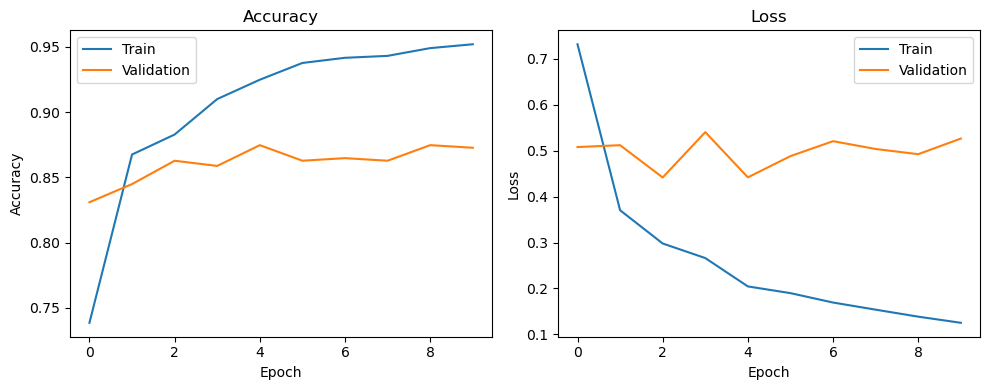

In [15]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Accuracy and Loss
final_train_acc = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]

final_val_acc = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9521
Final Training Loss: 0.1251
Final Validation Accuracy: 0.8728
Final Validation Loss: 0.5265


In [20]:
y_probs = model.predict(val_generator, verbose=1)

y_pred = np.argmax(y_probs, axis=1)

y_true = val_generator.classes

class_names = list(val_generator.class_indices.keys())

16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 980ms/step


In [22]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.17      0.17      0.17        80
       glass       0.24      0.24      0.24       100
       metal       0.20      0.21      0.21        82
       paper       0.27      0.22      0.24       118
     plastic       0.23      0.20      0.21        96
       trash       0.09      0.19      0.12        27

    accuracy                           0.21       503
   macro avg       0.20      0.20      0.20       503
weighted avg       0.22      0.21      0.21       503



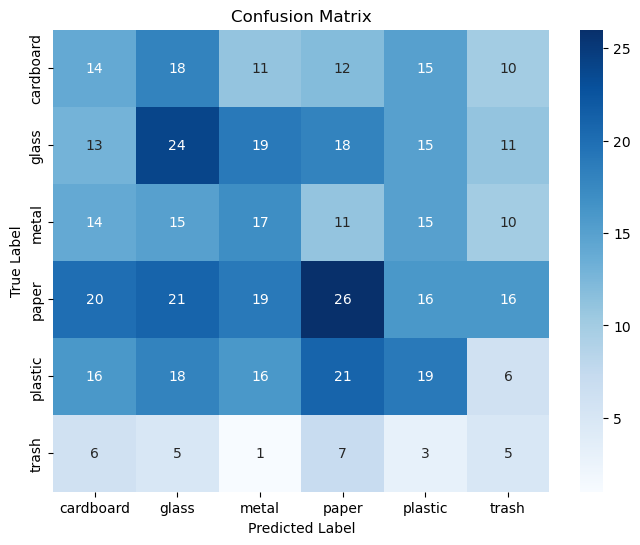

In [25]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


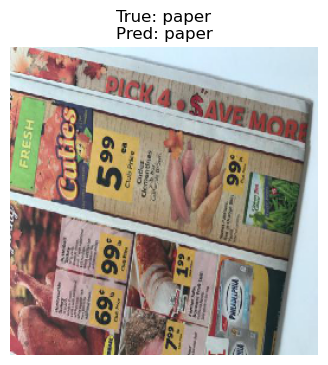

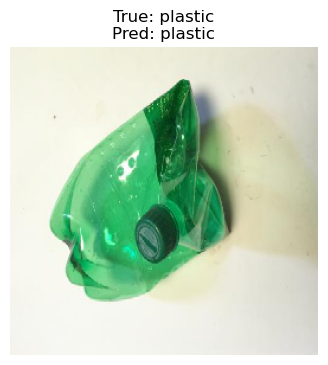

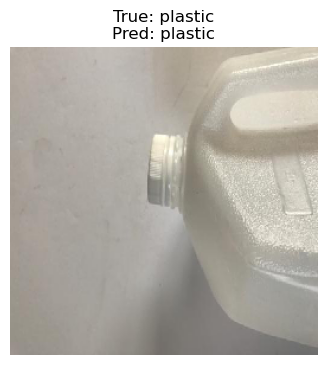

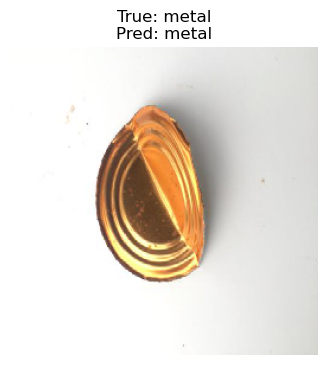

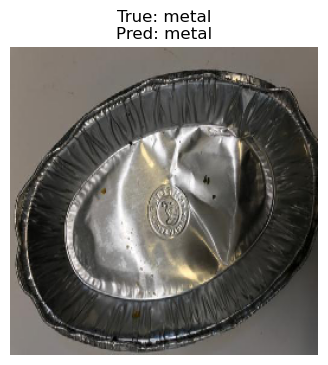

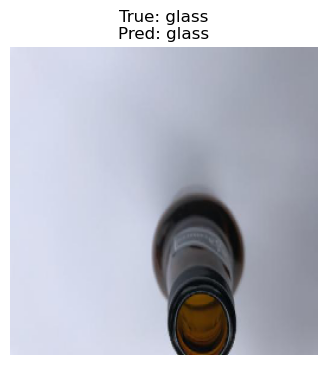

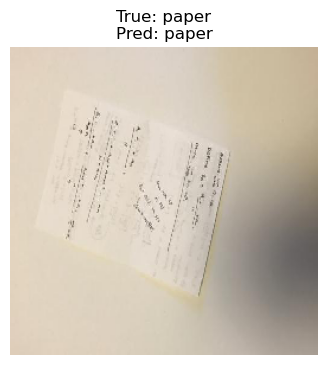

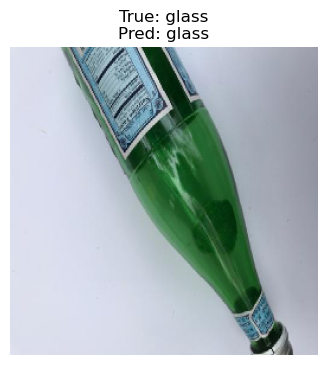

In [28]:
#Final test and predictions
class_names = list(train_generator.class_indices.keys())

images, labels = next(val_generator)

predictions = model.predict(images)

pred_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(labels, axis=1)

for i in range(8):
    plt.figure(figsize=(4, 4))
    plt.imshow(images[i].astype("uint8"))
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
    plt.axis("off")
    plt.show()

In [31]:
model.save('garbage_classifier_model.keras')

print("✅ Model saved successfully.")

model = tf.keras.models.load_model('garbage_classifier_model.keras')

print("✅ Model Loaded successfully.")

✅ Model saved successfully.
✅ Model Loaded successfully.


C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [32]:
#Building a interface using gradio
!pip install gradio


Defaulting to user installation because normal site-packages is not writeable


In [33]:
def classify_image(img):  
    img = img.resize((260, 260))  
    
    img_array = np.array(img, dtype=np.float32)
    
    img_array = preprocess_input(img_array)
    
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    
    predicted_class_index = np.argmax(prediction)
    
    predicted_class_name = class_names[predicted_class_index]
    
    confidence = prediction[0][predicted_class_index]
    
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"


In [38]:
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Garbage Classification Model",
    description="Upload an image to classify the type of garbage."
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://f83e74167d6efc7264.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
